In [1]:
#kernel_name=conda_mxnet_p27
#https://github.com/dmlc/mxnet-notebooks/blob/master/python/tutorials/mnist.ipynb

In [11]:
import sys
print(sys.version)

2.7.14 |Anaconda, Inc.| (default, Dec  7 2017, 17:05:42) 
[GCC 7.2.0]


In [18]:
import numpy as np
import os
import urllib
import gzip
import struct
import timeit

%matplotlib inline  
#NBB: this can be made obselete by editing jupyter config file to suit
import matplotlib.pyplot as plt
import mxnet as mx


In [3]:
def download_data(url, force_download=True): 
    #split url into pre/post '/', store the pre '/' component as fname
    fname = url.split("/")[-1]
    #retrieve from full url if forced o-wise retrieve from local file
    if force_download or not os.path.exists(fname):
        urllib.urlretrieve(url, fname)
    return fname


In [4]:
def read_data(label_url, image_url):
    #download two sets of data from the two urls provided.
    #this should be downloading one file from one url at a time.
    with gzip.open(download_data(label_url)) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)

    with gzip.open(download_data(image_url), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)


In [12]:
#NB: only need to download these files once.
#NBB: need to exclude these files from the git repo
start_time = timeit.default_timer()
path='http://yann.lecun.com/exdb/mnist/'
(train_lbl, train_img) = read_data(path+'train-labels-idx1-ubyte.gz', path+'train-images-idx3-ubyte.gz')
(val_lbl, val_img) = read_data(path+'t10k-labels-idx1-ubyte.gz', path+'t10k-images-idx3-ubyte.gz')
print "elapsed time :", timeit.default_timer() - start_time
print "train_lbl:", type(train_lbl), train_lbl.shape
print "train_img:", type(train_img), train_img.shape
print "val_lbl:", type(val_lbl), val_lbl.shape
print "val_img:", type(val_img), val_img.shape
#NB: the images are black and white (no greyscale, no rgb color) 
#the images are stored in arrays of dimension width x height.

elapsed time : 2.65278697014
train_lbl: <type 'numpy.ndarray'> (60000,)
train_img: <type 'numpy.ndarray'> (60000, 28, 28)
val_lbl: <type 'numpy.ndarray'> (10000,)
val_img: <type 'numpy.ndarray'> (10000, 28, 28)


In [16]:
print "train_img[0]:", type(train_img[0]), train_img[0].shape

train_img[0]: <type 'numpy.ndarray'> (28, 28)


In [29]:
print "train_img[0]:", train_img[0].dtype
#https://docs.scipy.org/doc/numpy-1.13.0/user/basics.types.html
#uint8	Unsigned integer (0 to 255)
print "Number of unique values:", np.unique(train_img).shape[0]
print "Unique values:\n", np.unique(train_img)

train_img[0]: uint8
Number of unique values: 256
Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230

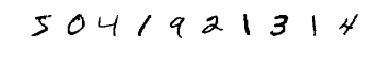

label: [5 0 4 1 9 2 1 3 1 4]


In [17]:
#plot first ten images
for i in range(10):
    plt.subplot(1,10,i+1)
    #plt.imshow(train_img[i], cmap='Greys_r')
    plt.imshow(train_img[i], cmap='Greys')
    plt.axis('off')
plt.show()
print('label: %s' % (train_lbl[0:10],))

#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html
#cmap : Colormap, optional, default: None
#nbb: cmap='Greys' vs cmap='Greys_r' (the _r is for inverse grayscale)

In [30]:
#reshape the input data to format normally expected for rgb images.ie from 3D array to 4D array.
#convert input data from integer values (0-255) to float values (0.0 to 1.0)
def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255


In [32]:
batch_size = 100
train_iter = mx.io.NDArrayIter(to4d(train_img), train_lbl, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(to4d(val_img), val_lbl, batch_size)
#mxnet.io.NDArrayIter = https://github.com/apache/incubator-mxnet/blob/master/python/mxnet/io.py
print "train_iter:", type(train_iter)
print "val_iter:", type(val_iter)

('train_iter:', <class 'mxnet.io.NDArrayIter'>)
('val_iter:', <class 'mxnet.io.NDArrayIter'>)


In [33]:
# Create a place holder variable for the input data
data = mx.sym.Variable('data')
#mxnet.symbol.Variable = https://mxnet.incubator.apache.org/api/python/symbol/symbol.html#mxnet.symbol.Variable

print "data:", type(data)

# Flatten the data from 4-D shape (batch_size, num_channel, width, height) 
# into 2-D (batch_size, num_channel*width*height)
data = mx.sym.Flatten(data=data)
#https://mxnet.incubator.apache.org/api/python/symbol/symbol.html
#mxnet.symbol.Flatten(data=None, name=None, attr=None, out=None, **kwargs)
#Flattens the input array into a 2-D array by collapsing the higher dimensions.
print "after flatten data:", type(data)


data: <class 'mxnet.symbol.symbol.Symbol'>
after flatten data: <class 'mxnet.symbol.symbol.Symbol'>


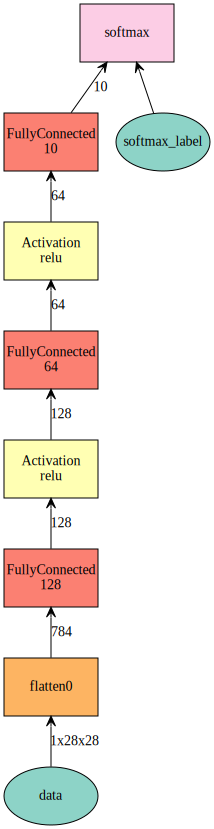

In [36]:
# The first fully-connected layer
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=128)
# Apply relu to the output of the first fully-connnected layer
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")

# The second fully-connected layer and the according activation function
fc2  = mx.sym.FullyConnected(data=act1, name='fc2', num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")

# The thrid fully-connected layer, note that the hidden size should be 10, which is the number of unique digits
fc3  = mx.sym.FullyConnected(data=act2, name='fc3', num_hidden=10)
# The softmax and loss layer
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

# We visualize the network structure with output size (the batch_size is ignored.)
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)
#https://mxnet.incubator.apache.org/faq/visualize_graph.html


In [37]:
print "fc1:", type(fc1)
print "act1:", type(act1)
print "fc2:", type(fc2)
print "act2:", type(act2)
print "fc3:", type(fc3)
print "mlp:", type(mlp)
#https://mxnet.incubator.apache.org/api/python/symbol/symbol.html

fc1: <class 'mxnet.symbol.symbol.Symbol'>
act1: <class 'mxnet.symbol.symbol.Symbol'>
fc2: <class 'mxnet.symbol.symbol.Symbol'>
act2: <class 'mxnet.symbol.symbol.Symbol'>
fc3: <class 'mxnet.symbol.symbol.Symbol'>
mlp: <class 'mxnet.symbol.symbol.Symbol'>


In [38]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
import logging
logging.getLogger().setLevel(logging.DEBUG)

start_time = timeit.default_timer()
model = mx.model.FeedForward(
    symbol = mlp,       # network structure
    num_epoch = 10,     # number of data passes for training 
    learning_rate = 0.1 # learning rate of SGD 
)
print "mx.model.FeedForward : elapsed time :", timeit.default_timer() - start_time

start_time = timeit.default_timer()
model.fit(
    X=train_iter,       # training data
    eval_data=val_iter, # validation data
    batch_end_callback = mx.callback.Speedometer(batch_size, 200) # output progress for each 200 data batches
)
print "model.fit : elapsed time :", timeit.default_timer() - start_time

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/mxnet/model.py:573: DeprecationWarning: Calling initializer with init(str, NDArray) has been deprecated.please use init(mx.init.InitDesc(...), NDArray) instead.
  self.initializer(k, v)
INFO:root:Start training with [cpu(0)]


mx.model.FeedForward : elapsed time : 0.00116419792175


INFO:root:Epoch[0] Batch [200]	Speed: 49247.85 samples/sec	accuracy=0.111300
INFO:root:Epoch[0] Batch [400]	Speed: 41009.90 samples/sec	accuracy=0.113550
INFO:root:Epoch[0] Batch [600]	Speed: 48657.20 samples/sec	accuracy=0.245050
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=3.420
INFO:root:Epoch[0] Validation-accuracy=0.501400
INFO:root:Epoch[1] Batch [200]	Speed: 48529.91 samples/sec	accuracy=0.618750
INFO:root:Epoch[1] Batch [400]	Speed: 47630.29 samples/sec	accuracy=0.797750
INFO:root:Epoch[1] Batch [600]	Speed: 48472.28 samples/sec	accuracy=0.848550
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=1.260
INFO:root:Epoch[1] Validation-accuracy=0.873600
INFO:root:Epoch[2] Batch [200]	Speed: 48585.31 samples/sec	accuracy=0.875950
INFO:root:Epoch[2] Batch [400]	Speed: 48573.77 samples/sec	accuracy=0.900600
INFO:root:Epoch[2] Batch [600]	Speed: 48054.16 samples/sec	accuracy=0.912350
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Ep

model.fit : elapsed time : 16.5171089172


In [39]:
#NB: git repo shows Validation-accuracy=0.968200
#my first attempt returns Validation-accuracy=0.970400

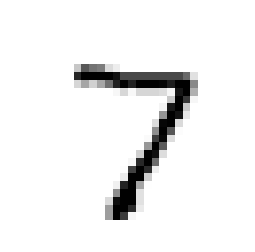

In [46]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
#plt.imshow(val_img[0], cmap='Greys_r')
plt.imshow(val_img[0], cmap='Greys')
plt.axis('off')
plt.show()

In [47]:

prob = model.predict(val_img[0:1].astype(np.float32)/255)[0]
print "prob:", type(prob), prob.shape
print prob
#NB: returns a probability for each category. 

assert max(prob) > 0.99, "Low prediction accuracy."
#https://wiki.python.org/moin/UsingAssertionsEffectively
#test if the highest accuracy is greater than x.xx, if not return string.

#identify the highest probability and present to user.
print 'Classified as %d with probability %f' % (prob.argmax(), max(prob))

prob: <type 'numpy.ndarray'> (10,)
[  7.39555395e-09   8.31057787e-06   8.11799764e-05   4.55100817e-04
   1.47988399e-09   4.32557012e-09   1.04167770e-12   9.99346435e-01
   3.95903226e-06   1.05051498e-04]
Classified as 7 with probability 0.999346


In [49]:
print "model:", type(model)
#https://mxnet.incubator.apache.org/api/python/model.html

model: <class 'mxnet.model.FeedForward'>


In [48]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
valid_acc = model.score(val_iter)
#score(X, eval_metric='acc', num_batch=None, batch_end_callback=None, reset=True)[source]
#recall val_iter is class 'mxnet.io.NDArrayIter'
#iterate through all the values, test accuracy of prediction.

print 'Validation accuracy: %f%%' % (valid_acc *100,)
assert valid_acc > 0.95, "Low validation accuracy."
#todo: identify wrong predictions. plot to see how bad the images are.
#todo: identify most frequent wrong prediction pairs. ie: are 1's predicted as 7 and vice versa.
#NBB: the 97% accuracy result is not great. have obtained better results with data augmentation and multi layers.

Validation accuracy: 97.040000%


In [ ]:
#now create and run a CNN model.

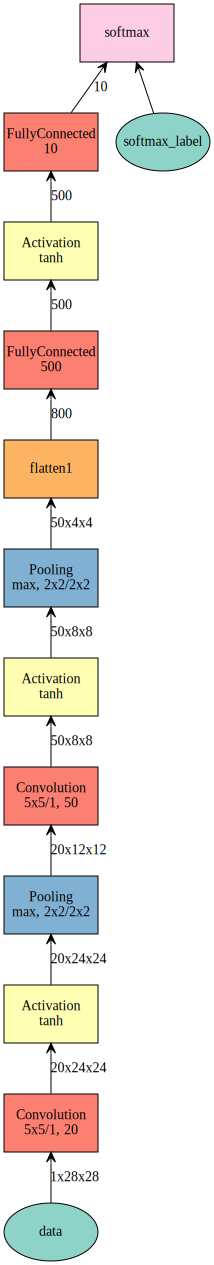

In [51]:
data = mx.symbol.Variable('data')
# first conv layer
conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# second conv layer
conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# first fullc layer
flatten = mx.sym.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# second fullc
fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# softmax loss
lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')
mx.viz.plot_network(symbol=lenet, shape=shape)

In [54]:
# @@@ AUTOTEST_OUTPUT_IGNORED_CELL
start_time = timeit.default_timer()
model = mx.model.FeedForward(
    ctx = mx.gpu(0),     # use GPU 0 for training, others are same as before
    symbol = lenet,       
    num_epoch = 20,     
    learning_rate = 0.1)
print "mx.model.FeedForward : elapsed time :", timeit.default_timer() - start_time

start_time = timeit.default_timer()
model.fit(
    X=train_iter,  
    eval_data=val_iter, 
    batch_end_callback = mx.callback.Speedometer(batch_size, 200)
) 
print "mx.model.FeedForward : elapsed time :", timeit.default_timer() - start_time

valid_acc = model.score(val_iter)
print 'Validation accuracy: %f%%' % (valid_acc *100,)
assert model.score(val_iter) > 0.98, "Low validation accuracy."

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: mxnet.model.FeedForward has been deprecated. Please use mxnet.mod.Module instead.
INFO:root:Start training with [gpu(0)]


mx.model.FeedForward : elapsed time : 0.00109791755676


INFO:root:Epoch[0] Batch [200]	Speed: 23125.29 samples/sec	accuracy=0.111350
INFO:root:Epoch[0] Batch [400]	Speed: 27672.62 samples/sec	accuracy=0.113550
INFO:root:Epoch[0] Batch [600]	Speed: 27686.26 samples/sec	accuracy=0.110850
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=2.322
INFO:root:Epoch[0] Validation-accuracy=0.113500
INFO:root:Epoch[1] Batch [200]	Speed: 27772.56 samples/sec	accuracy=0.198400
INFO:root:Epoch[1] Batch [400]	Speed: 27724.94 samples/sec	accuracy=0.838100
INFO:root:Epoch[1] Batch [600]	Speed: 27682.00 samples/sec	accuracy=0.926250
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=2.173
INFO:root:Epoch[1] Validation-accuracy=0.940400
INFO:root:Epoch[2] Batch [200]	Speed: 27816.61 samples/sec	accuracy=0.945550
INFO:root:Epoch[2] Batch [400]	Speed: 27736.05 samples/sec	accuracy=0.960750
INFO:root:Epoch[2] Batch [600]	Speed: 27759.15 samples/sec	accuracy=0.967900
INFO:root:Epoch[2] Resetting Data Iterator
INFO:root:Ep

mx.model.FeedForward : elapsed time : 46.925257206
Validation accuracy: 98.870000%
